# Automated MBS

To use the automated MBS from Power et al. 2021, follow the instructions bellow.

Power L , Acevedo L, Rubin D, Yamashita R, Martin I, Barbero A (2021) Deep learning 
enables the automation of grading histological tissue engineered cartilage images for
quality control standardization. Osteoarthritis and Cartilage [in press] 
https://doi.org/10.1016/j.joca.2020.12.018
                                                               
To run the code in the cells below, click in the cell and then **Ctrl + Enter** or **Run**

## Import modules

Import the following modules only once by running the cell:

In [5]:
import cv2 #pip install opencv-python
import math
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import numpy as np

from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## Create tiles from a larger image

Safranin O, Fast Green, and hematoxylin stained paraffin-embedded sections must be imaged at 20x.

Edit ***filename*** below, and then run the cell to create small tiles of the larger 20x image. 

In [6]:
##################################### 
#  Edit filename within quotes here, make sure there are no spaces in the name
#
file ="Whole_slide_image.tif"
#
#####################################

img = cv2.imread(file)
filename = os.path.splitext(file)[0]
print(filename)

img_shape = img.shape
tile_size = (336, 336) #original size was 224, 224 alternative size 336 or 448
offset = (336, 336)
count = 0 
os.makedirs("./temp/1") #If a folder with the name 1 already exists and you do not want to override it, rename the old folder
for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
    for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
        cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
        #save the tiles
        if cropped_img.shape[0] == 336 and cropped_img.shape[1] == 336:
            cv2.imwrite("./temp/1/" + filename + "_tile-" + str(i) + "-" + str(j) + ".tif", cropped_img)
            count += 1

print("{} tiles created from: {}.tif".format(count, filename))

num_classes = 4
batch_size = 6
imgSize = 336
data_dir = './temp' #All images are in a folder called 1
device = "cpu"
model = torchvision.models.densenet161(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)
model = model.to(device)
model.load_state_dict(torch.load(r"transfer_dict_densenet_class_encoded.pt",map_location=torch.device("cpu")))
#r before the string processes it as a raw string (i.e. no string formatting)

testdata_transforms = transforms.Compose([
        transforms.CenterCrop(imgSize),
        transforms.ToTensor(),
        transforms.Normalize([0.5894, 0.5352, 0.5669], [0.0749, 0.0701, 0.0634]) #mean and sd of training images
    ])

image_dataset = datasets.ImageFolder(data_dir, testdata_transforms)

testdataloader = torch.utils.data.DataLoader(image_dataset, batch_size=batch_size, num_workers=4)

model.eval()

dataiter = iter(testdataloader)
images, labels = dataiter.next()
scores = []
with torch.no_grad():
    for data in testdataloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        scores += predicted.tolist()

os.mkdir("scored_images")
MBS = {0: "MBS_0", 1: "MBS_1-2", 2: "MBS_3-4", 3: "MBS_5-6"}

for tile, score in zip(sorted(os.listdir("./temp/1")), scores):
    if tile != ".DS_Store":
        img = cv2.imread("./temp/1/" + tile)
        cv2.imwrite("./scored_images/" + MBS[score] + "_" + tile, img)

print("{} automated MBS: {:.2f}".format(filename, round(sum(scores) / len(scores) * 2, 2)))
print(len(scores))
print("{} tiles with score 0".format(scores.count(0)))
print("{} tiles with score 1-2".format(scores.count(1)))
print("{} tiles with score 3-4".format(scores.count(2)))
print("{} tiles with score 5-6".format(scores.count(3)))

Whole_slide_image
440 tiles created from: Whole_slide_image.tif


KeyboardInterrupt: 


# Visualize scores on the original image

Run the code below to visualize what parts of the original image were given which scores.

The tiles are color coded with:

<span style='background:cyan'>MBS 0</span>
<span style='background:yellow'>MBS 1-2</span>
<span style='background:orange'>MBS 3-4</span>
<span style='background:red'>MBS 5-6</span>

692 p1 4w A4
34 tiles with score 0
10 tiles with score 1-2
157 tiles with score 3-4
269 tiles with score 5-6
Average MBS: 4.812765957446809


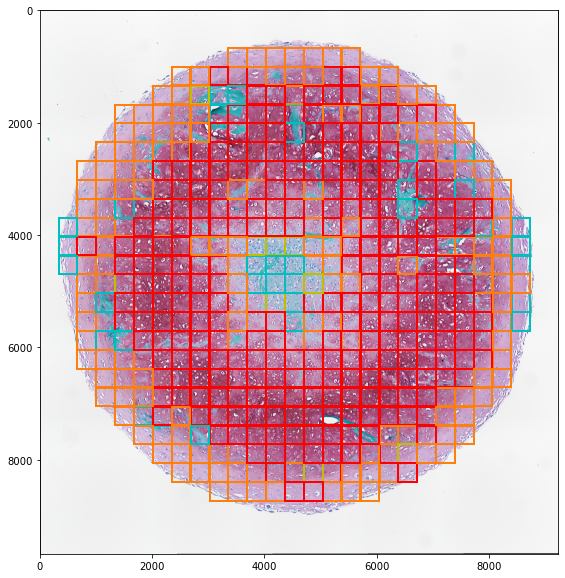

In [4]:
original = Image.open(file)
background = original.copy()
original.close()

plt.figure(figsize=(10, 10))
ax = plt.gca()
allscores = []
for tilename in os.listdir("./scored_images"):
    if tilename != ".DS_Store":
        tile = Image.open("./scored_images/" + tilename)
        position = tilename.split("_tile-")[1]
        pos = position.replace('.', '-').split("-")
        ypos = int(pos[0]) * 336 #original was 224
        xpos = int(pos[1]) * 336

        score = tilename.split("_")[1]
        allscores.append(score)
        score_color = {"0": "c", "1-2": "y", "3-4": "C1", "5-6": "r"}
        rect = Rectangle((xpos,ypos), 330, 330, linewidth=2, edgecolor=score_color[score], facecolor='none') #218,330,442
        ax.add_patch(rect)
        tile.close()

plt.imshow(background)

zero = allscores.count("0")
one = allscores.count("1-2")
two = allscores.count("3-4")
three = allscores.count("5-6")
avgMBS = (one*2 + two*4 + three*6)/(zero + one + two + three)
print(filename)
print("{} tiles with score 0".format(zero))
print("{} tiles with score 1-2".format(one))
print("{} tiles with score 3-4".format(two))
print("{} tiles with score 5-6".format(three))

print("Average MBS: {}".format(avgMBS))

plt.savefig("scored_tiles_MBS-" + str(round(avgMBS, 2)) + "_" + file)

## Automated scoring of the tiles

Go through the tiles in "scored_images" and delete all tiles that contain scaffold material, slide background, staining artifacts, tears in the tissue, etc. Rerun the code above.